In [1]:
# Import Packages and setup
from __future__ import print_function, division
import os
from collections import OrderedDict
import logging

import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# Make the plots look pretty
matplotlib.rc('font',size=13)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')
# Use the same color cylcer as Seaborn
from cycler import cycler
color_cycle = [u'#4c72b0', u'#55a868', u'#c44e52', u'#8172b2', u'#ccb974', u'#64b5cd']
matplotlib.rcParams['axes.prop_cycle'] = cycler("color", color_cycle)

import lsst.afw.table as afwTable
from lsst.afw.image import ImageI, PARENT
from lsst.utils import getPackageDir
import lsst.log as log
import lsst.meas.deblender
from lsst.meas.deblender import proximal, display, sim, baseline
import lsst.meas.deblender.utils as debUtils
import proxmin

logger = logging.getLogger("lsst.meas.deblender")
logger.setLevel(logging.INFO)
log.setLevel("", log.INFO)
plogger = logging.getLogger("proxmin")
plogger.setLevel(logging.INFO)
dlogger = logging.getLogger("deblender")
dlogger.setLevel(logging.INFO)

from lsst.daf.persistence import Butler

WORK_DIR = os.path.join("/tigress", "fredem", "lsst", "test_data")
butler = Butler(inputs=os.path.join(WORK_DIR, "rerun/example2"))

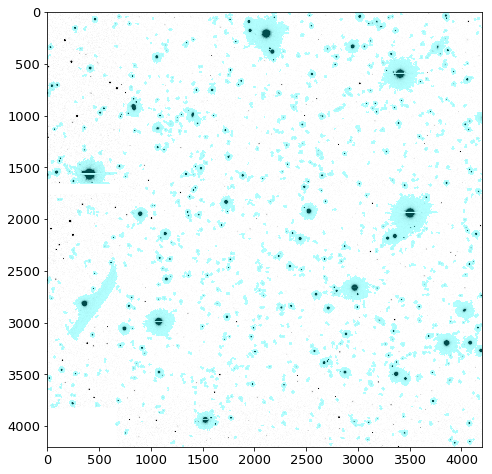

In [2]:
#visits = butler.queryMetadata('deepCoadd', ['visit'], dataId={'filter':'HSC-I'})
calexp = {}
for f in ["I", "R"]:
    calexp[f] = butler.get('deepCoadd_calexp', patch="1,1", filter="HSC-"+f, tract=0)
img = calexp["I"].getMaskedImage().getImage().getArray()
catalog = butler.get("deepCoadd_mergeDet", patch="1,1", tract=0)
tbl = catalog.asAstropy()
footprints = ImageI(calexp["I"].getBBox())
for n,src in enumerate(catalog):
    fp = src.getFootprint()
    peaks = fp.getPeaks()
    if len(peaks)>1:
        fp.getSpans().setImage(footprints, 1)

plt.figure(figsize=(8,8))
plt.imshow(img, vmax=10, cmap="Greys", vmin=0)
fpimg = np.ma.array(footprints.getArray())
fpimg.mask = fpimg==0
plt.imshow(fpimg, cmap="cool", alpha=.3)

In [3]:
for n,src in enumerate(catalog):
    fp = src.getFootprint()
    peaks = fp.getPeaks()
    bbox = fp.getBBox()
    sub = calexp["I"].Factory(calexp["I"], fp.getBBox(), PARENT)
    if len(peaks)>3 and bbox.getWidth()<80 and bbox.getHeight()<80 and np.max(sub.image.array)>5:
        print(len(peaks))
        break
print(len(catalog), n)

5
3490 39


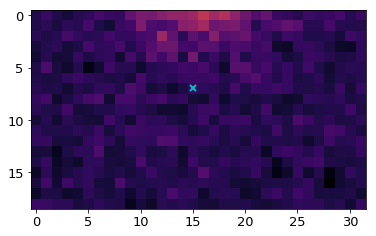

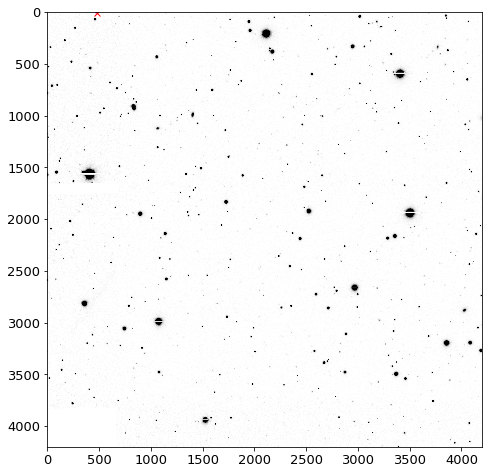

(minimum=(4362, 3903), maximum=(4393, 3921))
(minimum=(4362, 3903), maximum=(4393, 3921))


In [4]:
src = catalog[1]
fp = src.getFootprint()
subCalexp = calexp["I"].Factory(calexp["I"], fp.getBBox(), PARENT)
plt.imshow(subCalexp.image.array, vmax=10)
xmin = subCalexp.getBBox().getMinX()
ymin = subCalexp.getBBox().getMinY()
peaks = []
for pk in fp.getPeaks():
    x = pk.getIx()-xmin
    y = pk.getIy()-ymin
    peaks.append([x,y])
    plt.plot(x,y, 'cx', mew=2)
plt.show()

footprints = ImageI(calexp["I"].getBBox())
fp.getSpans().setImage(footprints, 1)
plt.figure(figsize=(8,8))
plt.imshow(img, vmax=10, cmap="Greys", vmin=0)
fpimg = np.ma.array(footprints.getArray())
fpimg.mask = fpimg==0
plt.imshow(fpimg, cmap="cool_r", alpha=.3)
plt.plot(pk.getIx()-calexp["I"].getBBox().getMinX(), pk.getIy()-calexp["I"].getBBox().getMinY(), 'rx')
plt.show()
print(subCalexp.getBBox())
print(fp.getBBox())

452 503


(0, 31L)

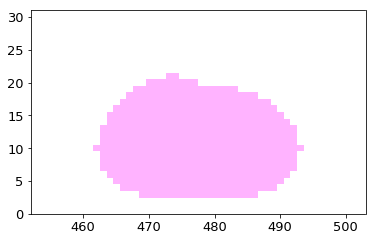

In [5]:
xmin = calexp["I"].getBBox().getMinX()
ymin = calexp["I"].getBBox().getMinY()
bbox = fp.getBBox()
plt.imshow(fpimg, cmap="cool_r", alpha=.3)
print(max(bbox.getMinX()-10-xmin, 0), bbox.getMaxX()+10-xmin)
plt.xlim([max(bbox.getMinX()-10-xmin, 0), bbox.getMaxX()+10-xmin])
plt.ylim([max(bbox.getMinY()-10-ymin, 0), bbox.getMaxY()+10-ymin])

In [6]:
np.where(~fpimg.mask)

(array([ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
         9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11,
        11, 

In [7]:
np.sum(~fpimg.mask)

457

In [8]:
fp.getSpans()

[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]
[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [9]:
import lsst.meas.deblender.plugins as plugins
reload(lsst.meas.deblender.plugins)
import lsst.meas.deblender.baseline
reload(lsst.meas.deblender.baseline)

import deblender.nmf
reload(deblender.nmf)
reload(plugins)

<module 'lsst.meas.deblender.plugins' from '/tigress/fredem/lsst/code/meas_deblender/python/lsst/meas/deblender/plugins.pyc'>

In [10]:
from lsst.meas.deblender import plugins
debPlugins = [
    plugins.DeblenderPlugin(plugins.build_multiband_templates, max_iter=200)
]
filters = ["I", "R"]

calexp["I"].Factory(calexp["I"], fp.getBBox(), PARENT)

images = [calexp[f].getMaskedImage() for f in filters]
psfs = [calexp[f].getPsf().computeKernelImage().array for f in filters]
db = baseline.newDeblend(debPlugins, fp, images, psfs, [8,8], filters)

INFO:proxmin.algorithms:Completed 201 iterations


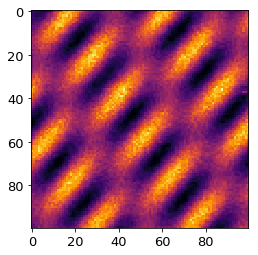

In [12]:
plt.imshow(db.maskedImages[0].variance.array[:100,:100])

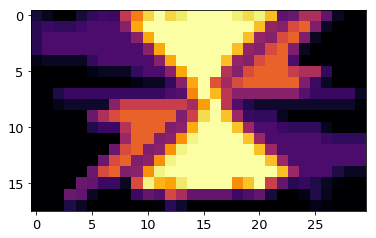

ValueError: operands could not be broadcast together with shapes (19,31) (18,30) 

In [11]:
k = 0

plt.imshow(db.peaks[k].deblendedPeaks["I"].templateImage.array)#, vmax=10)
plt.show()
result = db.multibandResult
model = deblender.nmf.get_peak_model(result.A, result.S, result.T.Gamma, shape=result.S.shape[1:], k=k)
plt.imshow(model[0] - db.peaks[k].deblendedPeaks["I"].templateImage.array)
plt.colorbar()

In [ ]:
peak = result.T.peaks.peaks[0]
models = []
for c, component in peak.components.items():
    models.append(deblender.nmf.get_peak_model(result.A, result.S, result.T.Gamma, result.shape,
                                                  component.index).astype(np.float32))
model = np.array(models)

In [ ]:
fidx = 0
imbb = db.deblendedParents[db.filters[0]].img.getBBox()
imbb

In [ ]:
import lsst.afw.image as afwImage
timg = afwImage.ImageF(model[fidx], xy0=debResult.footprint.getBBox().getBegin())
timg.getBBox()

In [ ]:
from lsst.afw.geom import SpanSet
from lsst.afw.detection import Footprint
debResult = db
model = models[0]
peak = result.T.peaks.peaks[0]

In [ ]:
_cx = int((result.S[0].shape[1]-1)/2)
_cy = int((result.S[0].shape[0]-1)/2)
result.A[fidx][0]*result.S[0][_cy][_cx]
print(_cx, _cy)

In [ ]:
result.S[0].shape[1]>>1

In [ ]:
print(db.footprint.getBBox())

In [ ]:
bbox = debResult.footprint.getBBox()

In [ ]:
from lsst.afw.geom import Point2I, Box2I, Extent2I

In [ ]:
fp.getBBox()

In [ ]:
fp = debResult.footprint
dx = _cx-result.T.peaks.peaks[0].x
dy = _cy-result.T.peaks.peaks[0].y
print(dx,dy)
cbox = Box2I(fp.getBBox())
cbox.shift(Extent2I(dx, dy))
cbox

In [ ]:
mask = afwImage.Mask(np.array(model[fidx]>0, dtype=np.int32), xy0=cbox.getBegin())
ss = SpanSet.fromMask(mask)
foot = Footprint(ss)
cx = int(np.round(peak.x))
cy = int(np.round(peak.y))
foot.addPeak(peak.x+.1, peak.y+.2, model[fidx][cy][cx])

In [ ]:
ss

In [ ]:
foot.getBBox()

In [ ]:
pk = 0
model = (result.A[fidx][pk]*result.S[pk]).astype(np.float32)
plt.imshow(model)

In [ ]:
timg = afwImage.ImageF(model, xy0=cbox.getBegin())
timg.getBBox()

In [ ]:
ibox = Box2I(fp.getBBox().getBegin(), Extent2I(100,100))
ibox.shift(Extent2I(-20,-20))
ti = afwImage.ImageF(ibox)
si = ti.Factory(ti, foot.getBBox(), PARENT)

In [ ]:
si = timg
plt.imshow(si.array)

In [ ]:
plt.imshow(ti.array)

In [ ]:
ss.setImage(ti, 3)

In [ ]:
plt.imshow(ti.array)

In [ ]:
peak = result.T.peaks.peaks[0]
models = []
for c, component in peak.components.items():
    models.append(deblender.nmf.get_peak_model(result.A, result.S, result.T.Gamma, result.shape,
                                                  component.index).astype(np.float32))
m = np.array(models)

plt.imshow(m[0][0])